# MCMC

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

import numpy as np
import jax.numpy as jn
from  matplotlib import pyplot as plt
import jax
from jax import random

from src.utils import l2sq
from src.algorithm import *

plt.rcParams["figure.figsize"]=8,8

(-12.0, 12.0)

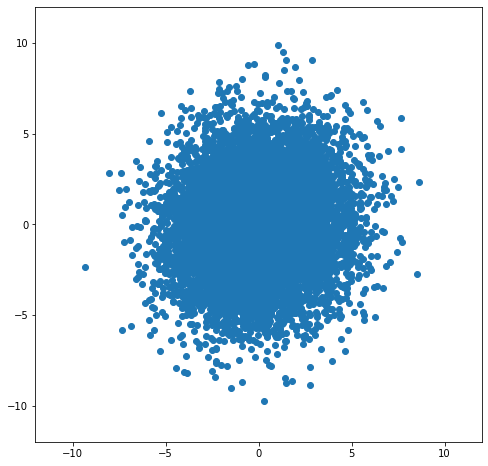

In [2]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

k = 10
M = jnp.zeros(k)
#c = jnp.array([[1,0],[0,10]])
#c_inv = jnp.array([[1, 0], [0,1/10]])

key, *sk = random.split(key, 4)
V = random.normal(sk[0], [k, k])
Q, _ = jnp.linalg.qr(V)
d = jnp.diag(random.uniform(sk[1], (k,))*10)
D= d.at[d < 0].set(0)
C = Q.transpose() @ D @ Q
C_inv = Q.transpose() @ jnp.diag(1/jnp.diag(D)) @ Q

S = random.multivariate_normal(sk[2], M, C, (10000,))
plt.scatter(S[:,0], S[:,1])
plt.xlim(-12,12)
plt.ylim(-12,12)

In [3]:
S.shape

(10000, 10)

In [4]:
def plot_mcmc_samples(samples, r, x0, M, C):

    plt.rcParams["figure.figsize"]=16,8

    plt.subplot(1,2,1)
    plt.plot(x0[0], x0[1], 'ro')
    plt.scatter(samples[:,0], samples[:,1])
    plt.xlim(-20,20)
    plt.ylim(-20,20)

    plt.subplot(1,2,2)
    plt.plot(r)

    plt.rcParams["figure.figsize"]=8,8

    M_est = jnp.mean(samples, axis = 0)
    print("Mean error =", jnp.linalg.norm(M - M_est))

    C_est = jnp.cov(samples.transpose())
    print("Covariance error =", jnp.linalg.norm(C - C_est)/jnp.linalg.norm(C))

In [5]:
logPi = lambda x : -1/2 * (x-M) @ C_inv @ (x-M) - jnp.log(jnp.sqrt((2*jnp.pi)**k * jnp.linalg.det(C)))
gradLogPi = jax.grad(logPi)

pi = lambda x : jnp.exp(logPi(x))
logPi = jax.jit(logPi)
gradLogPi = jax.jit(gradLogPi)

In [ ]:
#logPi(jnp.array([10,20]))
#gradLogPi(jnp.array([0.,-5.]))

In [ ]:
#x = jnp.arange(-20,20)
#y = [pi(jnp.array([0,xi])) for xi in x]
#plt.plot(x,y)
#plt.show
#y2 = [pi(jnp.array([xi,0])) for xi in x]
#plt.plot(x,y2)
#plt.show()
#y3 = [logPi(jnp.array([0,xi])) for xi in x]
#plt.plot(x,y3)

#gradLogPi(jnp.array([0.,-5.]))

In [6]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))
N_samples = 1000
x0 = jnp.array(np.random.randn(k))

### MALA

In [ ]:
proposal_params_mala = {"tau" : 0.01}

x_mean_mala, r_mala, samples_mala = mcmc(key, N_samples, proposal_mala, logPi, gradLogPi, x0, proposal_params_mala, 1)

In [ ]:
plot_mcmc_samples(samples_mala, r_mala, x0, M, C)

### HMC

In [7]:
N_samples=1000

In [22]:
@jax.jit
def proposal_hmc_jit(key, x0, logPiX0, dt_list):
    return proposal_hmc(key, x0, logPiX0, logPi, gradLogPi, dt_list, L=100)    
    
    

In [23]:
logPiX0 = jnp.inf 
print(logPi(x0))
dt_list = jnp.array([0.1])
x1, r, logPiX1, logPiX0 = proposal_hmc_jit(key, x0, logPiX0, dt_list)

print(logPiX0)
logPiX1

-17.249471391069058
-17.249471391069058


DeviceArray(-17.62447178, dtype=float64)

In [24]:
proposal_params_hmc = {"dt_list" : jnp.array([0.001, 0.01, 0.1, 1, 10])}

x_mean_hmc, r_hmc, samples_hmc = mcmc(key, proposal_hmc_jit, x0, N_samples, proposal_params_hmc, save_samples=1)


  MCMC sample 100, loss = 21.65388403131913, a = 0.0
  MCMC sample 200, loss = 19.061962601968695, a = 1.0
  MCMC sample 300, loss = 18.82738224341155, a = 0.9999813079606356
  MCMC sample 400, loss = 20.81005844982489, a = 0.7828540972933888
  MCMC sample 500, loss = 19.24002949114605, a = 1.0
  MCMC sample 600, loss = 25.93310738157779, a = 0.8723896949145994
  MCMC sample 700, loss = 24.777680839745443, a = 0.0
  MCMC sample 800, loss = 18.635148368924398, a = 1.0
  MCMC sample 900, loss = 21.059790596513828, a = 1.0


Mean error = 0.6249860136751121
Covariance error = 0.15840662267560804


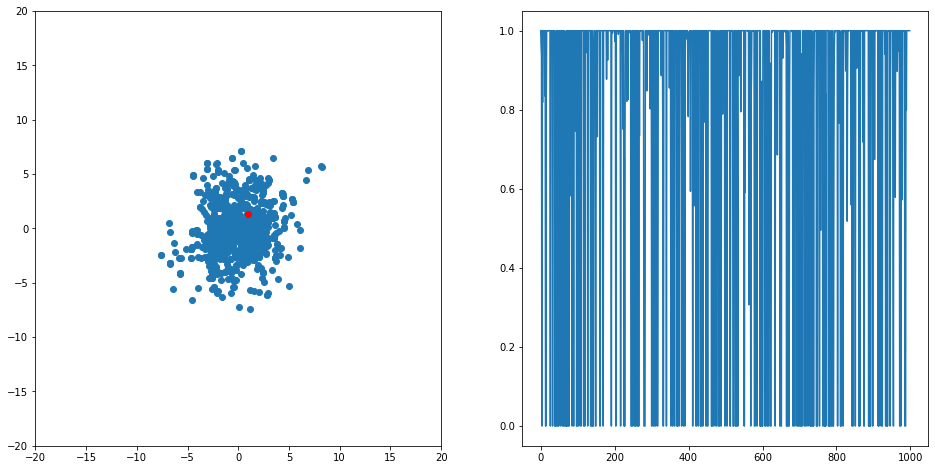

In [25]:
plot_mcmc_samples(samples_hmc, r_hmc, x0, M, C)

In [26]:
def get_norm_conv(samples, M, C):
    norm_m = []
    norm_c = []
    for i in range(10,N_samples):
        if jnp.mod(i,50) == 0:
            Merr = jnp.linalg.norm(jnp.mean(samples[:i], axis = 0) - M)
            Cerr = jnp.linalg.norm(jnp.cov(samples[:i].transpose()) - C)/jnp.linalg.norm(C)
            norm_m.append(Merr)
            norm_c.append(Cerr)

    norm_m = jnp.array(norm_m)
    norm_c = jnp.array(norm_c)
    return norm_m, norm_c

In [27]:
samples_hmc.shape

(999, 10)

In [28]:
norm_m_hmc, norm_c_hmc = get_norm_conv(samples_hmc, M, C)

In [29]:
norm_m_an, norm_c_an = get_norm_conv(S, M, C)

In [30]:
#norm_m_mala, norm_c_mala = get_norm_conv(samples_mala, M, C)

In [31]:
xx = []
for i in range(50,N_samples):
    if jnp.mod(i, 50) == 0:
        xx.append(i)
xx = jnp.array(xx)
yy = 1/jnp.sqrt(xx)

In [32]:
norm_m_hmc.shape

(19,)

In [33]:
xx.shape

(19,)

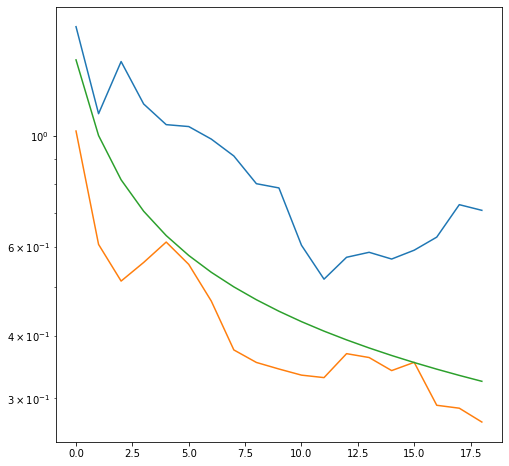

In [38]:
#plt.semilogy(norm_m_mala)
plt.semilogy(norm_m_hmc)
plt.semilogy(norm_m_an)
plt.semilogy(yy*10)

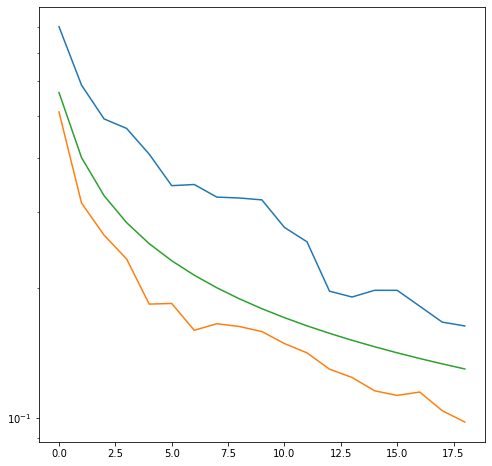

In [41]:
#plt.semilogy(norm_c_mala)
plt.semilogy(norm_c_hmc)
plt.semilogy(norm_c_an)
plt.semilogy(yy*4)